## Aim 

The aim of this module is to implement the part of speech tagging (POS) mechanism to identify the type of speech associated with a particular word. Tagging can be tricky since some words might appear in different context and hence be associated with different part of speech.

* The whole team played well. [adverb]
* You are doing well for yourself. [adjective]
* Well, this assignment took me forever to complete. [interjection]
* The well is dry. [noun]* 
Tears were beginning to well in her eyes. [verb]


During the course of this module we would be learning :
* Learn how parts-of-speech tagging works
* Compute the transition matrix A in a Hidden Markov Model
* Compute the emission matrix B in a Hidden Markov Model
* Compute the Viterbi algorithm
* Compute the accuracy of your own model

## Data Source
* The tagged training data has been preprocessed to form a vocabulary (hmm_vocab.txt).
* The words in the vocabulary are words from the training set that were used two or more times.
* The vocabulary is augmented with a set of 'unknown word tokens', described below.

When POS tagger would encounter a missing word:
* To improve accuracy, these words are further analyzed during preprocessing to extract available hints as to their appropriate tag.
* For example, the suffix 'ize' is a hint that the word is a verb, as in 'final-ize' or 'character-ize'.
* A set of unknown-tokens, such as '--unk-verb--' or '--unk-noun--' will replace the unknown words in both the training and test corpus and will appear in the emission, transmission and tag data structures.



In [ ]:
# Importing packages and loading in the data set 
import pandas as pd
from collections import defaultdict
import math
import numpy as np
import string

In [ ]:
# Mount the drive to access the relevant data 

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open("/content/gdrive/My Drive/WSJ_02-21.pos", 'r') as f:
    training_corpus = f.readlines()

print(f"A few items of the training corpus list")
print(training_corpus[0:5])

A few items of the training corpus list
['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n']


In [ ]:
with open("/content/gdrive/My Drive/hmm_vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

print("A few items of the vocabulary list")
print(voc_l[0:50])
print()
print("A few items at the end of the vocabulary list")
print(voc_l[-50:])

A few items of the vocabulary list
['!', '#', '$', '%', '&', "'", "''", "'40s", "'60s", "'70s", "'80s", "'86", "'90s", "'N", "'S", "'d", "'em", "'ll", "'m", "'n'", "'re", "'s", "'til", "'ve", '(', ')', ',', '-', '--', '--n--', '--unk--', '--unk_adj--', '--unk_adv--', '--unk_digit--', '--unk_noun--', '--unk_punct--', '--unk_upper--', '--unk_verb--', '.', '...', '0.01', '0.0108', '0.02', '0.03', '0.05', '0.1', '0.10', '0.12', '0.13', '0.15']

A few items at the end of the vocabulary list
['yards', 'yardstick', 'year', 'year-ago', 'year-before', 'year-earlier', 'year-end', 'year-on-year', 'year-round', 'year-to-date', 'year-to-year', 'yearlong', 'yearly', 'years', 'yeast', 'yelled', 'yelling', 'yellow', 'yen', 'yes', 'yesterday', 'yet', 'yield', 'yielded', 'yielding', 'yields', 'you', 'young', 'younger', 'youngest', 'youngsters', 'your', 'yourself', 'youth', 'youthful', 'yuppie', 'yuppies', 'zero', 'zero-coupon', 'zeroing', 'zeros', 'zinc', 'zip', 'zombie', 'zone', 'zones', 'zoning', '{',

In [ ]:
vocab = {} 

# Get the index of the corresponding words. 
for i, word in enumerate(sorted(voc_l)): 
    vocab[word] = i       
    
print("Vocabulary dictionary, key is the word, value is a unique integer")
cnt = 0
for k,v in vocab.items():
    print(f"{k}:{v}")
    cnt += 1
    if cnt > 20:
        break
        

Vocabulary dictionary, key is the word, value is a unique integer
:0
!:1
#:2
$:3
%:4
&:5
':6
'':7
'40s:8
'60s:9
'70s:10
'80s:11
'86:12
'90s:13
'N:14
'S:15
'd:16
'em:17
'll:18
'm:19
'n':20


In [ ]:
# load in the test corpus
with open("/content/gdrive/My Drive/WSJ_24.pos", 'r') as f:
    y = f.readlines()

print("A sample of the test corpus")
print(y[0:10])

A sample of the test corpus
['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n', 'be\tVB\n', 'taken\tVBN\n', 'from\tIN\n', 'several\tJJ\n', 'vantage\tNN\n']


In [ ]:
# Punctuation characters
punct = set(string.punctuation)

# Morphology rules used to assign unknown word tokens
noun_suffix = ["action", "age", "ance", "cy", "dom", "ee", "ence", "er", "hood", "ion", "ism", "ist", "ity", "ling", "ment", "ness", "or", "ry", "scape", "ship", "ty"]
verb_suffix = ["ate", "ify", "ise", "ize"]
adj_suffix = ["able", "ese", "ful", "i", "ian", "ible", "ic", "ish", "ive", "less", "ly", "ous"]
adv_suffix = ["ward", "wards", "wise"]

In [ ]:
# define some utility functions 
def get_word_tag(line, vocab): 
    if not line.split():
        word = "--n--"
        tag = "--s--"
        return word, tag
    else:
        word, tag = line.split()
        if word not in vocab: 
            # Handle unknown words
            word = assign_unk(word)
        return word, tag
    return None 

def preprocess(vocab, data_fp):
    """
    Preprocess data
    """
    orig = []
    prep = []

    # Read data
    with open(data_fp, "r") as data_file:

        for cnt, word in enumerate(data_file):

            # End of sentence
            if not word.split():
                orig.append(word.strip())
                word = "--n--"
                prep.append(word)
                continue

            # Handle unknown words
            elif word.strip() not in vocab:
                orig.append(word.strip())
                word = assign_unk(word)
                prep.append(word)
                continue

            else:
                orig.append(word.strip())
                prep.append(word.strip())

    assert(len(orig) == len(open(data_fp, "r").readlines()))
    assert(len(prep) == len(open(data_fp, "r").readlines()))

    return orig, prep

def assign_unk(tok):
    """
    Assign unknown word tokens
    """
    # Digits
    if any(char.isdigit() for char in tok):
        return "--unk_digit--"

    # Punctuation
    elif any(char in punct for char in tok):
        return "--unk_punct--"

    # Upper-case
    elif any(char.isupper() for char in tok):
        return "--unk_upper--"

    # Nouns
    elif any(tok.endswith(suffix) for suffix in noun_suffix):
        return "--unk_noun--"

    # Verbs
    elif any(tok.endswith(suffix) for suffix in verb_suffix):
        return "--unk_verb--"

    # Adjectives
    elif any(tok.endswith(suffix) for suffix in adj_suffix):
        return "--unk_adj--"

    # Adverbs
    elif any(tok.endswith(suffix) for suffix in adv_suffix):
        return "--unk_adv--"

    return "--unk--"


In [ ]:
#corpus without tags, preprocessed
_, prep = preprocess(vocab, "/content/gdrive/My Drive/test.words")     

print('The length of the preprocessed test corpus: ', len(prep))
print('This is a sample of the test_corpus: ')
print(prep[0:10])

The length of the preprocessed test corpus:  34199
This is a sample of the test_corpus: 
['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


## Part of speech tagging 

There are some words which have multiple tags and hence are ambiguous , 
In the training .
* the word is a verb and it is not ambiguous.
* In the WSJ corpus, 86% corpus is unambigous . 
* About 14% are ambigious .


### Calculating some dictionaries for future computations .

* Transition counts : This dictionary is used to calculate the frequency of the instances from one word to another . P(t(x)/t(x-1)) indicates trasition from one state t(x-1) to another t(x) . In this scenario we have the following cases - 
  * Key : (prev_tag, tag) , value : # two tags appeared in that order.

### Emmission count:
This dict would indicate the frequency of instances from one state to a word . The probability is P(w(x)/t(x)) . Here :
  * Key : (tag, word) , value : # the word occured with that POS tag.

### Tag Count 
Key : tags , value: # a tag appeared in the dictionary .


In [ ]:
def create_dictionaries(training_corpus, vocab):
    """
    Input: 
        training_corpus: a corpus where each line has a word followed by its tag.
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output: 
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
        tag_counts: a dictionary where the keys are the tags and the values are the counts
    """
    
    # initialize the dictionaries using defaultdict
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    # Initialize "prev_tag" (previous tag) with the start state, denoted by '--s--'
    prev_tag = '--s--' 
    
    # use 'i' to track the line number in the corpus
    i = 0 
    
    # Each item in the training corpus contains a word and its POS tag
    # Go through each word and its tag in the training corpus
    for word_tag in training_corpus:
        
        # Increment the word_tag count
        i += 1
        
        # Every 50,000 words, print the word count
        if i % 50000 == 0:
            print(f"word count = {i}")
            
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        # get the word and tag using the get_word_tag helper function (imported from utils_pos.py)
        word, tag = get_word_tag(word_tag, vocab)
        
        # Increment the transition count for the previous word and tag
        transition_counts[(prev_tag, tag)] += 1
        
        # Increment the emission count for the tag and word
        emission_counts[(tag, word)] += 1

        # Increment the tag count
        tag_counts[tag] += 1

        # Set the previous tag to this tag (for the next iteration of the loop)
        prev_tag = tag 
        
        ### END CODE HERE ###
        
    return emission_counts, transition_counts, tag_counts

In [ ]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)
# get the POS states 
states = sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states)

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
Number of POS tags (number of 'states'): 46
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [ ]:

print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': print (tup, cnt) 

transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4


## Testing 

* first we will assign POS tag to every word . 
* Determine what percentage was correct .


In [ ]:
def predict_pos(prep, y, emission_counts, vocab, states):
    '''
    Input: 
        prep: a preprocessed version of 'y'. A list with the 'word' component of the tuples.
        y: a corpus composed of a list of tuples where each tuple consists of (word, POS)
        emission_counts: a dictionary where the keys are (tag,word) tuples and the value is the count
        vocab: a dictionary where keys are words in vocabulary and value is an index
        states: a sorted list of all possible tags for this assignment
    Output: 
        accuracy: Number of times you classified a word correctly
    '''
    
    # Initialize the number of correct predictions to zero
    num_correct = 0
    
    # Get the (tag, word) tuples, stored as a set
    all_words = set(emission_counts.keys())
    
    # Get the number of (word, POS) tuples in the corpus 'y'
    total = len(y)
    for word, y_tup in zip(prep, y): 

        # Split the (word, POS) string into a list of two items
        y_tup_l = y_tup.split()
        
        # Verify that y_tup contain both word and POS
        if len(y_tup_l) == 2:
            
            # Set the true POS label for this word
            true_label = y_tup_l[1]

        else:
            # If the y_tup didn't contain word and POS, go to next word
            continue
    
        count_final = 0
        pos_final = ''
        
        # If the word is in the vocabulary...
        if word in vocab:
            for pos in states:

            ### START CODE HERE (Replace instances of 'None' with your code) ###
                        
                # define the key as the tuple containing the POS and word
                key = (pos,word)

                # check if the (pos, word) key exists in the emission_counts dictionary
                if key in emission_counts.keys(): # complete this line

                # get the emission count of the (pos,word) tuple 
                    count = emission_counts.get(key,0)

                    # keep track of the POS with the largest count
                    if count_final < count: # complete this line

                        # update the final count (largest count)
                        count_final = count

                        # update the final POS
                        pos_final = pos

            # If the final POS (with the largest count) matches the true POS:
            if pos_final == y_tup[1]: # complete this line
                
                # Update the number of correct predictions
                num_correct += 1
            
    ### END CODE HERE ###
    accuracy = num_correct / total
    
    return accuracy

In [ ]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.0003


## Hidden Markov Model for POS 

* We would be using the Viterbi decoder to implement the Hidden Markov Model 

HMM contains the probability tranisitons between different states : 
* In this case, the states are the parts-of-speech.
* A Markov Model utilizes a transition matrix, A.
* A Hidden Markov Model adds an observation or emission matrix B which * describes the probability of a visible observation when we are in a particular state.
* In this case, the emissions are the words in the corpus The state, which is hidden, is the POS tag of that word.


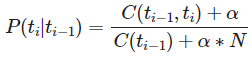

*  N is the total number of tags .
*  C(t(i-1),t(i)) is the count of the tuple (previous POS, current POS) in transition_counts dictionary.
* C(t(i-1)) is the count of the previous POS in the tag_counts dictionary.
*  α is a smoothing parameter.

In [ ]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    ''' 
    Input: 
        alpha: number used for smoothing
        tag_counts: a dictionary mapping each tag to its respective count
        transition_counts: transition count for the previous word and tag
    Output:
        A: matrix of dimension (num_tags,num_tags)
    '''
    # Get a sorted list of unique POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Count the number of unique POS tags
    num_tags = len(all_tags)
    
    # Initialize the transition matrix 'A'
    A = np.zeros((num_tags,num_tags))
    
    # Get the unique transition tuples (previous POS, current POS)
    trans_keys = set(transition_counts.keys())
    
    ### START CODE HERE (Replace instances of 'None' with your code) ### 
    
    # Go through each row of the transition matrix A
    for i in range(num_tags):
        
        # Go through each column of the transition matrix A
        for j in range(num_tags):

            # Initialize the count of the (prev POS, current POS) to zero
            count = 0
        
            # Define the tuple (prev POS, current POS)
            # Get the tag at position i and tag at position j (from the all_tags list)
            key = (all_tags[i], all_tags[j])

            # Check if the (prev POS, current POS) tuple 
            # exists in the transition counts dictionary
            if key in transition_counts.keys(): #complete this line
                
                # Get count from the transition_counts dictionary 
                # for the (prev POS, current POS) tuple
                count = transition_counts[key]
                
            # Get the count of the previous tag (index position i) from tag_counts
            count_prev_tag = tag_counts[all_tags[i]]
            
            # Apply smoothing using count of the tuple, alpha, 
            # count of previous tag, alpha, and total number of tags
            A[i,j] = (count + alpha) / (count_prev_tag + alpha * num_tags)

    ### END CODE HERE ###
    
    return A

In [ ]:
alpha = 0.001
A = create_transition_matrix(alpha, tag_counts, transition_counts)
# Testing your function
print(f"A at row 0, col 0: {A[0,0]:.9f}")
print(f"A at row 3, col 1: {A[3,1]:.4f}")

print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
View a subset of transition matrix A
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02


## Emission Probability table 

Now we would define the emissione prob table .
Now you will create the B transition matrix which computes the emission probability. You will use smoothing as defined below:

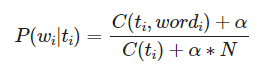

**The technique would be exactly the same as the transitiona matrix**




In [ ]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    '''
    Input: 
        alpha: tuning parameter used in smoothing 
        tag_counts: a dictionary mapping each tag to its respective count
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        vocab: a dictionary where keys are words in vocabulary and value is an index.
               within the function it'll be treated as a list
    Output:
        B: a matrix of dimension (num_tags, len(vocab))
    '''
    
    # get the number of POS tag
    num_tags = len(tag_counts)
    
    # Get a list of all POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Get the total number of unique words in the vocabulary
    num_words = len(vocab)
    
    # Initialize the emission matrix B with places for
    # tags in the rows and words in the columns
    B = np.zeros((num_tags, num_words))
    
    # Get a set of all (POS, word) tuples 
    # from the keys of the emission_counts dictionary
    emis_keys = set(list(emission_counts.keys()))
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    
    # Go through each row (POS tags)
    for i in range(len(all_tags)): # complete this line
        
        # Go through each column (words)
        for j in range(num_words): # complete this line

            # Initialize the emission count for the (POS tag, word) to zero
            count = 0
                    
            # Define the (POS tag, word) tuple for this row and column
            key =  (all_tags[i],vocab[j])

            # check if the (POS tag, word) tuple exists as a key in emission counts
            if emission_counts.keys(): # complete this line
        
                # Get the count of (POS tag, word) from the emission_counts d
                count = emission_counts[key]
                
            # Get the count of the POS tag
            count_tag = tag_counts[all_tags[i]]
                
            # Apply smoothing and store the smoothed value 
            # into the emission matrix B for this row and column
            B[i,j] = (count + alpha) / (count_tag + alpha*num_tags)

    ### END CODE HERE ###
    return B

In [ ]:
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)

View Matrix position at row 0, column 0: 0.000007040
View Matrix position at row 3, column 1: 0.000000732
              725      adroitly     engineers      promoted       synergy
CD   8.206618e-05  2.734628e-08  2.734628e-08  2.734628e-08  2.734628e-08
NN   7.522471e-09  7.522471e-09  7.522471e-09  7.522471e-09  2.257493e-05
NNS  1.670675e-08  1.670675e-08  4.678057e-04  1.670675e-08  1.670675e-08
VB   3.782428e-08  3.782428e-08  3.782428e-08  3.782428e-08  3.782428e-08
RB   3.228926e-08  6.461082e-05  3.228926e-08  3.228926e-08  3.228926e-08
RP   3.756509e-07  3.756509e-07  3.756509e-07  3.756509e-07  3.756509e-07


## Viterbi Algorithm ( using Dynamic Programming )

In this section we woudl implementing the Viterbi Algorithm . There are three main components to implementing the Viterbi algorithm , 
 * Initialization .
 * Forward Pass. 
 * Backward Pass.

## Initialization 
We would start by initialization  of the matric 

**best_probs**: Each cell contains the probability of going from one POS tag to a word in the corpus.

**best_paths**: A matrix that helps you trace through the best possible path in the corpus.

In [ ]:
def initialize(states, tag_counts, A, B, corpus, vocab):
    '''
    Input: 
        states: a list of all possible parts-of-speech
        tag_counts: a dictionary mapping each tag to its respective count
        A: Transition Matrix of dimension (num_tags, num_tags)
        B: Emission Matrix of dimension (num_tags, len(vocab))
        corpus: a sequence of words whose POS is to be identified in a list 
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        best_probs: matrix of dimension (num_tags, len(corpus)) of floats
        best_paths: matrix of dimension (num_tags, len(corpus)) of integers
    '''
    # Get the total number of unique POS tags
    num_tags = len(tag_counts)
    
    # Initialize best_probs matrix 
    # POS tags in the rows, number of words in the corpus as the columns
    best_probs = np.zeros((num_tags, len(corpus)))
    
    # Initialize best_paths matrix
    # POS tags in the rows, number of words in the corpus as columns
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)
    
    # Define the start token
    s_idx = states.index("--s--")
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    
    # Go through each of the POS tags
    for i in range(num_tags): # complete this line
        
        # Handle the special case when the transition from start token to POS tag i is zero
        if A[s_idx,i] == 0: # complete this line
            
            # Initialize best_probs at POS tag 'i', column 0, to negative infinity
            best_probs[i,0] = -23454566788
        
        # For all other cases when transition from start token to POS tag i is non-zero:
        else:
            
            # Initialize best_probs at POS tag 'i', column 0
            # Check the formula in the instructions above
            best_probs[i,0] = math.log(A[s_idx,i]) + math.log(B[i,vocab[corpus[0]]])

                        
    ### END CODE HERE ### 
    return best_probs, best_paths

In [ ]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [ ]:
# Test the function
print(f"best_probs[0,0]: {best_probs[0,0]:.4f}") 
print(f"best_paths[2,3]: {best_paths[2,3]:.4f}")

best_probs[0,0]: -22.4553
best_paths[2,3]: 0.0000


## Viterbi Forward Pass 

Now we would implement the forward pass of the Viterbi algorithms 
Following are the steps involved in the algorithms 


*   Walk forward through the corpus.
*   For each word, compute a probability for each possible tag.
*   Unlike the previous algorithm predict_pos (the 'warm-up' exercise), this will include the path up to that (word,tag) combination.



In [ ]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab):
    '''
    Input: 
        A, B: The transition and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initilized matrix of dimension (num_tags, len(corpus))
        best_paths: an initilized matrix of dimension (num_tags, len(corpus))
        vocab: a dictionary where keys are words in vocabulary and value is an index 
    Output: 
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    '''
    # Get the number of unique POS tags (which is the num of rows in best_probs)
    num_tags = best_probs.shape[0]
    
    # Go through every word in the corpus starting from word 1
    # Recall that word 0 was initialized in `initialize()`
    for i in range(1, len(test_corpus)): 
        
        # Print number of words processed, every 5000 words
        if i % 5000 == 0:
            print("Words processed: {:>8}".format(i))
            
        ### START CODE HERE (Replace instances of 'None' with your code EXCEPT the first 'best_path_i = None') ###
        # For each unique POS tag that the current word can be
        for j in range(num_tags): # complete this line
            
            # Initialize best_prob for word i to negative infinity
            best_prob_i = float("-inf")
            
            # Initialize best_path for current word i to None
            best_path_i = None

            # For each POS tag that the previous word can be:
            for k in range(num_tags): # complete this line
            
                # Calculate the probability = 
                # best probs of POS tag k, previous word i-1 + 
                # log(prob of transition from POS k to POS j) + 
                # log(prob that emission of POS j is word i)
                prob = best_probs[k][i-1] + np.log(A[k][j]) + np.log(B[j][vocab[test_corpus[i]]])

                # check if this path's probability is greater than
                # the best probability up to and before this point
                if prob > best_prob_i: # complete this line
                    
                    # Keep track of the best probability
                    best_prob_i = prob
                    
                    # keep track of the POS tag of the previous word
                    # that is part of the best path.  
                    # Save the index (integer) associated with 
                    # that previous word's POS tag
                    best_path_i = k

            # Save the best probability for the 
            # given current word's POS tag
            # and the position of the current word inside the corpus
            best_probs[j,i] = best_prob_i
            
            # Save the unique integer ID of the previous POS tag
            # into best_paths matrix, for the POS tag of the current word
            # and the position of the current word inside the corpus.
            best_paths[j,i] = best_path_i

        ### END CODE HERE ###
    return best_probs, best_paths

In [ ]:
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab)

Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000


## Using the backward pass here 

* This would allow us to generate the probability values for the words based on the sequences of data .


In [ ]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    '''
    This function returns the best path.
    
    '''
    # Get the number of words in the corpus
    # which is also the number of columns in best_probs, best_paths
    m = best_paths.shape[1] 
    
    # Initialize array z, same length as the corpus
    z = [None] * m
    
    # Get the number of unique POS tags
    num_tags = best_probs.shape[0]
    
    # Initialize the best probability for the last word
    best_prob_for_last_word = float('-inf')
    
    # Initialize pred array, same length as corpus
    pred = [None] * m
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    ## Step 1 ##
    
    # Go through each POS tag for the last word (last column of best_probs)
    # in order to find the row (POS tag integer ID) 
    # with highest probability for the last word
    for k in range(num_tags): # complete this line

        # If the probability of POS tag at row k 
        # is better than the previously best probability for the last word:
        if best_probs[k,-1] > best_prob_for_last_word: # complete this line
            
            # Store the new best probability for the lsat word
            best_prob_for_last_word = best_probs[k,-1]
    
            # Store the unique integer ID of the POS tag
            # which is also the row number in best_probs
            z[m - 1] = k
            
    # Convert the last word's predicted POS tag
    # from its unique integer ID into the string representation
    # using the 'states' dictionary
    # store this in the 'pred' array for the last word
    pred[m - 1] = states[k]
    
    ## Step 2 ##
    # Find the best POS tags by walking backward through the best_paths
    # From the last word in the corpus to the 0th word in the corpus
    for i in range(len(corpus)-1, -1, -1): # complete this line
        
        # Retrieve the unique integer ID of
        # the POS tag for the word at position 'i' in the corpus
        pos_tag_for_word_i = best_paths[np.argmax(best_probs[:,i]),i]
        
        # In best_paths, go to the row representing the POS tag of word i
        # and the column representing the word's position in the corpus
        # to retrieve the predicted POS for the word at position i-1 in the corpus
        z[i - 1] = best_paths[pos_tag_for_word_i,i]
        
        # Get the previous word's POS tag in string form
        # Use the 'states' dictionary, 
        # where the key is the unique integer ID of the POS tag,
        # and the value is the string representation of that POS tag
        pred[i - 1] = states[pos_tag_for_word_i]
        
     ### END CODE HERE ###
    return pred

In [ ]:
# Run and test your function
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']


## Predicting on the data set

Now  we would be predicting the accuracy of the model using our HMM model .


In [ ]:
def compute_accuracy(pred, y):
    '''
    Input: 
        pred: a list of the predicted parts-of-speech 
        y: a list of lines where each word is separated by a '\t' (i.e. word \t tag)
    Output: 
        
    '''
    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        # Split the label into the word and the POS tag
        word_tag_tuple = y.split()
        
        # Check that there is actually a word and a tag
        # no more and no less than 2 items
        if len(word_tag_tuple)!=2: # complete this line
            continue 

        # store the word and tag separately
        word, tag = word_tag_tuple
        
        # Check if the POS tag label matches the prediction
        if prediction == tag: # complete this line
            
            # count the number of times that the prediction
            # and label match
            num_correct += 1
            
        # keep track of the total number of examples (that have valid labels)
        total += 1
        
        ### END CODE HERE ###
    return num_correct/total

In [ ]:
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

Accuracy of the Viterbi algorithm is 0.9526


# Conclusion 

Now we can see how we can improve the model accuracy by using the HMM model in contrast to simple frequency model , based on basic probabilistic techniques.